# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
#run_info = run_info.query('path=="runs/01Aug20-032649-8cadf9"').iloc[0]
print(run_info)

path                                            runs/26Aug20-162040-a5ffd9
param_hash                                                          a5ffd9
start_time                                             2020-08-26 16:20:04
mpnn_config_directory                                      ./notebooks/xtb
mpnn_model_files         ['./notebooks/xtb/bootstrap-ensemble/networks/...
initial_agent                    ./notebooks/xtb/moldqn-training/agent.pkl
initial_search_space        ./notebooks/xtb/moldqn-training/best_mols.json
initial_database                     ./notebooks/xtb/initial_database.json
reference_energies                       ./notebooks/xtb/ref_energies.json
qc_spec                                     ./notebooks/xtb/qc_config.json
parallel_guesses                                                       112
parallel_updating                                                        1
rl_episodes                                                             10
search_size              

## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'simulation_records.jsonld'), lines=True).query('success')
result_data.sort_values('time_created', inplace=True)

In [5]:
result_data.reset_index(inplace=True)

Compute start time for the job

In [6]:
with open(os.path.join(run_info['path'], 'environment.json')) as fp:
    env = json.load(fp)
start_time = datetime.fromtimestamp(float(env['COBALT_STARTTIME']))

Plot the time since first result

In [7]:
result_data['walltime'] = result_data['time_result_received'] - start_time.timestamp()

Plot the rate at which we aquired new results

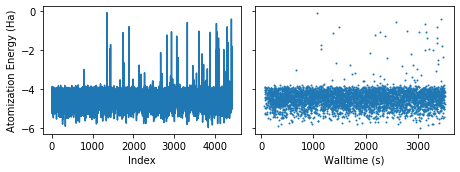

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].plot(result_data.index, result_data['value'])
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Atomization Energy (Ha)')

axs[1].scatter(result_data['walltime'], result_data['value'], s=1)
axs[1].set_xlabel('Walltime (s)')

fig.tight_layout()

## Evaluate Runtimes
Estimate the runtimes of the QC code

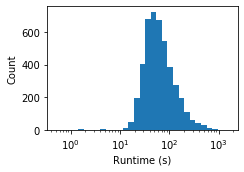

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

wt_range = np.log10([result_data['time_running'].min() * 0.9,
                     result_data['time_running'].max() * 1.1])
ax.hist(result_data['time_running'], bins=np.logspace(*wt_range, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Evaluate Overhead
Measure the time executing vs the end-to-end time for each of the tasks

In [10]:
rl_data = pd.read_json(os.path.join(run_info['path'], 'generate_records.jsonld'), lines=True)

In [11]:
screen_data = pd.read_json(os.path.join(run_info['path'], 'screen_records.jsonld'), lines=True)

In [12]:
update_data = pd.read_json(os.path.join(run_info['path'], 'update_records.jsonld'), lines=True)

Compute overhead

In [13]:
for data in [result_data, rl_data, screen_data, update_data]:
    data['overhead_time'] = (data['time_result_received'] - data['time_created']) - data['time_running']
    data['overhead_frac'] = 1 - data['time_running'] / (data['time_result_received'] - data['time_created'])

Plot overhead

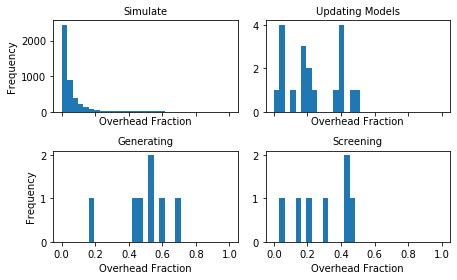

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.), sharex=True)

for data, label, ax in zip([result_data, update_data, rl_data, screen_data], ['Simulate', 'Updating Models', 'Generating', 'Screening'], axs.flatten()):
    ax.hist(data['overhead_frac'].tolist(), bins=np.linspace(0, 1, 32))
    ax.set_xlabel('Overhead Fraction')
    ax.set_title(f'{label}', fontsize=10)
    
for ax in axs[:, 0]:
    ax.set_ylabel('Frequency')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-fraction.svg'))

### Explain the overhead
See if we can explain the overhead events for the tasks

Compute each step

In [15]:
for data in [result_data, rl_data, screen_data, update_data]:
    data['client_to_method-server'] = data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])
    data['method-server_to_worker'] = data['time_compute_started'] - data['time_input_received']
    data['worker_to_method-server'] = data['time_result_sent'] - (data['time_compute_started']
                                                                  + data['time_running']
                                                                  + data['time_deserialize_inputs']
                                                                  + data['time_serialize_results'])
    data['method-server_to_client'] = data['time_result_received'] - (data['time_result_sent'] + data['time_deserialize_results'])
    data['serialization'] = data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c]].sum(axis=1)

Plot overheads

In [16]:
rl_data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c] + ['worker_to_method-server']]

,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,worker_to_method-server
0,0.810276,11.884406,2.309631,2.395167,4.151898
1,0.411797,10.436930,1.508755,4.460485,3.454420
2,0.248000,10.920502,1.121841,3.378479,3.432972
3,0.287769,11.203824,1.428869,1.645089,3.631833
4,0.294113,10.118513,1.130022,2.030443,2.767556
5,0.292512,11.694227,2.243972,1.671025,5.626196
6,0.301082,16.813949,1.424000,1.709454,3.631114


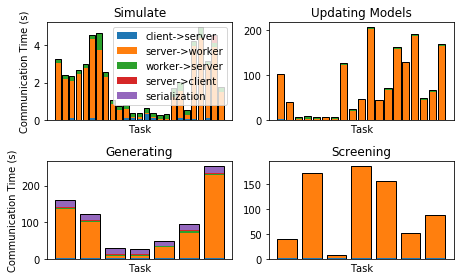

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.))

for data, label, ax in zip([result_data, update_data, rl_data, screen_data],
                           ['Simulate', 'Updating Models', 'Generating', 'Screening'], 
                           axs.flatten()):
    subset = data.sort_values('time_created', ascending=True).tail(min(25, len(data)))
    steps = ['client_to_method-server', 'method-server_to_worker', 'worker_to_method-server', 'method-server_to_client', 'serialization']
    x = np.arange(len(subset))
    for i in range(len(steps)):
        start = subset[steps[:i]].sum(axis=1).values
        ax.bar(x, subset[steps[i]].values, bottom=start, label=steps[i].replace("_to_", "->").replace('method-server', 'server'))
    ax.bar(x, subset['overhead_time'].values, edgecolor='k', facecolor='none', lw=1)
    
    ax.set_xticks([])
    ax.set_title(label)
    ax.set_xlabel('Task')
    
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Communication Time (s)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-breakdown.svg'))

*Finding*: It generally seems like the time from the task being recieved by the method server to starting on the compute note is generally the longest. Need to figure out what the issue is.

## Plot the Number of Results Being Run at a Time
We can look at the completed QC records to compute the utilization

Find the events related to calculations starting and finishing

In [18]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t - start_time.timestamp(), 'active_delta': -1} for t in result_data[['time_compute_started', 'time_running']].sum(axis=1))
events.extend({'time': t - start_time.timestamp(), 'active_delta': 1} for t in result_data['time_compute_started'])
events = pd.DataFrame(events)

Make the results easier to plot

In [19]:
events.sort_values('time', ascending=True, inplace=True)

In [20]:
events['num_active'] = events['active_delta'].cumsum()

In [21]:
events.tail()

,time,active_delta,num_active
4413,3506.367192,-1,4
4417,3506.400416,-1,3
4374,3506.415816,-1,2
4335,3506.449516,-1,1
4389,3509.015399,-1,0


Compute worker utilization

In [22]:
events['queue_length'] = events['num_active']

In [23]:
events['utilization'] = np.clip(events['queue_length'] / run_info['parallel_guesses'], 0, 1)

In [24]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

In [25]:
events['cumulative_utilization'] = None
events['cumulative_utilization'] = utilization_int / events['time'].iloc[1:]

Plot the queue length and utilization

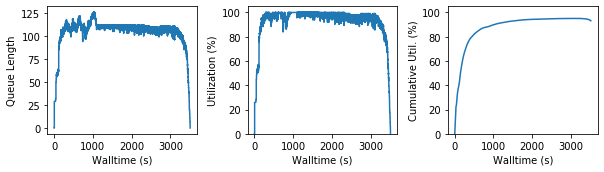

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['queue_length'], where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Queue Length')

ax = axs[1]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[2]
ax.plot(events['time'], events['cumulative_utilization'] * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()

*Finding*: Utilization stays around ~90% for the most of the run. The dropoff towards the end is because tasks that launched did not complete before the end of the allocation period.